 # ADDA for ST

 Creating something like CellDART but it actually follows Adda in PyTorch as a first step

In [1]:
import math
import os
import datetime
from copy import deepcopy
from itertools import count
import warnings

from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import h5py
import pickle
import numpy as np


import torch
from torch.nn import functional as F
from torch import nn

from src.da_models.adda import ADDAST
from src.da_models.datasets import SpotDataset
from src.da_models.utils import set_requires_grad
from src.da_models.utils import initialize_weights
from src.utils.dupstdout import DupStdout
from src.utils.data_loading import (
    load_spatial,
    load_sc,
    get_selected_dir,
    get_model_rel_path,
)
from src.utils.evaluation import format_iters


# datetime object containing current date and time
script_start_time = datetime.datetime.now().strftime("%Y-%m-%d_%Hh%Mm%S")


/tmp/ipykernel_812052/1153905422.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
if device == "cpu":
    warnings.warn("Using CPU", stacklevel=2)


In [3]:
DATA_DIR = "data"
TRAIN_USING_ALL_ST_SAMPLES = False
N_MARKERS = 20
ALL_GENES = False

ST_SPLIT = False
N_SPOTS = 20000
N_MIX = 8
SCALER_NAME = "celldart"

SAMPLE_ID_N = "151673"



BATCH_SIZE = 1024
NUM_WORKERS = 4
INITIAL_TRAIN_EPOCHS = 100


MIN_EPOCHS = 0.4 * INITIAL_TRAIN_EPOCHS
EARLY_STOP_CRIT = INITIAL_TRAIN_EPOCHS

MODEL_NAME = "ADDA"
MODEL_VERSION = "celldart"

adda_kwargs = {
    "emb_dim": 64,
    "bn_momentum": 0.99,
}


In [4]:
## Adversarial Hyperparameters

EPOCHS = 200
MIN_EPOCHS_ADV = 0.4 * EPOCHS
EARLY_STOP_CRIT_ADV = EPOCHS
ENC_LR = 0.0002
ADAM_BETA_1 = 0.5
ALPHA = 2
DIS_LOOP_FACTOR = 5


In [5]:
model_folder = get_model_rel_path(
    MODEL_NAME,
    MODEL_VERSION,
    scaler_name=SCALER_NAME,
    n_markers=N_MARKERS,
    all_genes=ALL_GENES,
    n_mix=N_MIX,
    n_spots=N_SPOTS,
    st_split=ST_SPLIT,
)
model_folder = os.path.join("model", model_folder)

if not os.path.isdir(model_folder):
    os.makedirs(model_folder)
    print(model_folder)



model/ADDA/celldart


 # Data load

In [7]:
# Load spatial data
mat_sp_d, mat_sp_train, st_sample_id_l = load_spatial(
    get_selected_dir(DATA_DIR, N_MARKERS, ALL_GENES),
    SCALER_NAME,
    train_using_all_st_samples=TRAIN_USING_ALL_ST_SAMPLES,
    st_split=ST_SPLIT,
)

# Load sc data
sc_mix_d, lab_mix_d, sc_sub_dict, sc_sub_dict2 = load_sc(
    get_selected_dir(DATA_DIR, N_MARKERS, ALL_GENES),
    SCALER_NAME,
    n_mix=N_MIX,
    n_spots=N_SPOTS,
)



 # Training: Adversarial domain adaptation for cell fraction estimation

 ## Prepare dataloaders

In [8]:
### source dataloaders
source_train_set = SpotDataset(sc_mix_d["train"], lab_mix_d["train"])
source_val_set = SpotDataset(sc_mix_d["val"], lab_mix_d["val"])
source_test_set = SpotDataset(sc_mix_d["test"], lab_mix_d["test"])

dataloader_source_train = torch.utils.data.DataLoader(
    source_train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=False,
)
dataloader_source_val = torch.utils.data.DataLoader(
    source_val_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=False,
)
dataloader_source_test = torch.utils.data.DataLoader(
    source_test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=False,
)

### target dataloaders
target_train_set_d = {}
dataloader_target_train_d = {}
if ST_SPLIT:
    target_val_set_d = {}
    target_test_set_d = {}

    dataloader_target_val_d = {}
    dataloader_target_test_d = {}
    for sample_id in st_sample_id_l:
        target_train_set_d[sample_id] = SpotDataset(mat_sp_d[sample_id]["train"])
        target_val_set_d[sample_id] = SpotDataset(mat_sp_d[sample_id]["val"])
        target_test_set_d[sample_id] = SpotDataset(mat_sp_d[sample_id]["test"])

        dataloader_target_train_d[sample_id] = torch.utils.data.DataLoader(
            target_train_set_d[sample_id],
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKERS,
            pin_memory=False,
        )
        dataloader_target_val_d[sample_id] = torch.utils.data.DataLoader(
            target_val_set_d[sample_id],
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=NUM_WORKERS,
            pin_memory=False,
        )
        dataloader_target_test_d[sample_id] = torch.utils.data.DataLoader(
            target_test_set_d[sample_id],
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=NUM_WORKERS,
            pin_memory=False,
        )

else:
    target_test_set_d = {}
    dataloader_target_test_d = {}

    target_train_set_dis_d = {}
    dataloader_target_train_dis_d = {}
    for sample_id in st_sample_id_l:
        target_train_set_d[sample_id] = SpotDataset(mat_sp_d[sample_id]["train"])
        dataloader_target_train_d[sample_id] = torch.utils.data.DataLoader(
            target_train_set_d[sample_id],
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKERS,
            pin_memory=False,
        )

        target_test_set_d[sample_id] = SpotDataset(
            deepcopy(mat_sp_d[sample_id]["test"])
        )
        dataloader_target_test_d[sample_id] = torch.utils.data.DataLoader(
            target_test_set_d[sample_id],
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=NUM_WORKERS,
            pin_memory=False,
        )

        target_train_set_dis_d[sample_id] = SpotDataset(
            deepcopy(mat_sp_d[sample_id]["train"])
        )
        dataloader_target_train_dis_d[sample_id] = torch.utils.data.DataLoader(
            target_train_set_dis_d[sample_id],
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKERS,
            pin_memory=False,
        )
        
if TRAIN_USING_ALL_ST_SAMPLES:
    target_train_set = SpotDataset(mat_sp_train)
    dataloader_target_train = torch.utils.data.DataLoader(
        target_train_set,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )
   

 ## Define Model

In [9]:
model = ADDAST(
    inp_dim=sc_mix_d["train"].shape[1],
    ncls_source=lab_mix_d["train"].shape[1],
    is_adda=True,
    **adda_kwargs
)
model.apply(initialize_weights)
model.to(device)


ADDAST(
  (source_encoder): ADDAMLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=360, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.5, inplace=False)
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): BatchNorm1d(512, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.01)
      (7): Dropout(p=0.5, inplace=False)
      (8): Linear(in_features=512, out_features=64, bias=True)
      (9): ELU(alpha=1.0)
    )
  )
  (clf): AddaPredictor(
    (head): Sequential(
      (0): Linear(in_features=64, out_features=33, bias=True)
    )
  )
)

 ## Pretrain

In [10]:
pretrain_folder = os.path.join(model_folder, "pretrain")

if not os.path.isdir(pretrain_folder):
    os.makedirs(pretrain_folder)


In [11]:
pre_optimizer = torch.optim.Adam(
    model.parameters(), lr=0.002, betas=(0.9, 0.999), eps=1e-07
)

pre_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    pre_optimizer,
    max_lr=0.002,
    steps_per_epoch=len(dataloader_source_train),
    epochs=INITIAL_TRAIN_EPOCHS,
)

criterion_clf = nn.KLDivLoss(reduction="batchmean")


In [12]:
def model_loss(x, y_true, model):
    x = x.to(torch.float32).to(device)
    y_true = y_true.to(torch.float32).to(device)

    y_pred = model(x)

    loss = criterion_clf(y_pred, y_true)

    return loss


def compute_acc(dataloader, model):
    loss_running = []
    mean_weights = []
    model.eval()
    with torch.no_grad():
        for _, batch in enumerate(dataloader):

            loss = model_loss(*batch, model)

            loss_running.append(loss.item())

            # we will weight average by batch size later
            mean_weights.append(len(batch))

    return np.average(loss_running, weights=mean_weights)


In [13]:
model.pretraining()


In [14]:
# Initialize lists to store loss and accuracy values
loss_history = []
loss_history_val = []

loss_history_running = []

# Early Stopping
best_loss_val = np.inf
early_stop_count = 0

with DupStdout().dup_to_file(os.path.join(pretrain_folder, "log.txt"), "w") as f_log:
    # Train
    print("Start pretrain...")
    outer = tqdm(total=INITIAL_TRAIN_EPOCHS, desc="Epochs", position=0)
    inner = tqdm(total=len(dataloader_source_train), desc=f"Batch", position=1)

    checkpoint = {
        "epoch": -1,
        "model": model,
        "optimizer": pre_optimizer,
        "scheduler": pre_scheduler,
        # 'scaler': scaler
    }
    for epoch in range(INITIAL_TRAIN_EPOCHS):
        checkpoint["epoch"] = epoch

        # Train mode
        model.train()
        loss_running = []
        mean_weights = []

        inner.refresh()  # force print final state
        inner.reset()  # reuse bar
        for _, batch in enumerate(dataloader_source_train):
            # lr_history_running.append(scheduler.get_last_lr())

            pre_optimizer.zero_grad()
            loss = model_loss(*batch, model)
            loss_running.append(loss.item())
            mean_weights.append(
                len(batch)
            )  # we will weight average by batch size later

            # scaler.scale(loss).backward()
            # scaler.step(optimizer)
            # scaler.update()

            loss.backward()
            pre_optimizer.step()
            pre_scheduler.step()

            inner.update(1)

        loss_history.append(np.average(loss_running, weights=mean_weights))
        loss_history_running.append(loss_running)

        # Evaluate mode
        model.eval()
        with torch.no_grad():
            curr_loss_val = compute_acc(dataloader_source_val, model)
            loss_history_val.append(curr_loss_val)

        # Print the results
        outer.update(1)
        print(
            "epoch:",
            epoch,
            "train loss:",
            round(loss_history[-1], 6),
            "validation loss:",
            round(loss_history_val[-1], 6),
            # "next_lr:", scheduler.get_last_lr(),
            end=" ",
        )
        # Save the best weights
        if curr_loss_val < best_loss_val:
            best_loss_val = curr_loss_val
            torch.save(checkpoint, os.path.join(pretrain_folder, f"best_model.pth"))
            early_stop_count = 0

            print("<-- new best val loss")
        else:
            print("")

        # Save checkpoint every 10
        if epoch % 10 == 0 or epoch >= INITIAL_TRAIN_EPOCHS - 1:
            torch.save(checkpoint, os.path.join(pretrain_folder, f"checkpt{epoch}.pth"))

        # check to see if validation loss has plateau'd
        if early_stop_count >= EARLY_STOP_CRIT and epoch >= MIN_EPOCHS - 1:
            print(
                f"Validation loss plateaued after {early_stop_count} at epoch {epoch}"
            )
            torch.save(
                checkpoint, os.path.join(pretrain_folder, f"earlystop{epoch}.pth")
            )
            break

        early_stop_count += 1

    # Save final model
    best_checkpoint = torch.load(os.path.join(pretrain_folder, f"best_model.pth"))
    torch.save(best_checkpoint, os.path.join(pretrain_folder, f"final_model.pth"))


Start pretrain...


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Batch:   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0 train loss: 2.762357 validation loss: 1.697811 <-- new best val loss
epoch: 1 train loss: 2.120073 validation loss: 1.366797 <-- new best val loss
epoch: 2 train loss: 1.787264 validation loss: 1.185491 <-- new best val loss
epoch: 3 train loss: 1.564373 validation loss: 1.05621 <-- new best val loss
epoch: 4 train loss: 1.393811 validation loss: 0.991781 <-- new best val loss
epoch: 5 train loss: 1.273648 validation loss: 0.924185 <-- new best val loss
epoch: 6 train loss: 1.173527 validation loss: 0.89462 <-- new best val loss
epoch: 7 train loss: 1.099546 validation loss: 0.850576 <-- new best val loss
epoch: 8 train loss: 1.036236 validation loss: 0.8277 <-- new best val loss
epoch: 9 train loss: 0.986487 validation loss: 0.805859 <-- new best val loss
epoch: 10 train loss: 0.936751 validation loss: 0.782023 <-- new best val loss
epoch: 11 train loss: 0.902647 validation loss: 0.75819 <-- new best val loss
epoch: 12 train loss: 0.869128 validation loss: 0.739499 <-- new be

 ## Adversarial Adaptation

In [15]:
advtrain_folder = os.path.join(model_folder, "advtrain")

if not os.path.isdir(advtrain_folder):
    os.makedirs(advtrain_folder)


In [16]:
def cycle_iter(iter):
    while True:
        yield from iter


def iter_skip(iter, n=1):
    for i in range(len(iter) * n):
        if (i % n) == n - 1:
            yield next(iter)
        else:
            yield None, None


In [17]:
criterion_dis = nn.BCEWithLogitsLoss()


In [18]:
def discrim_loss_accu(x, domain, model):
    x = x.to(device)

    if domain == "source":
        y_dis = torch.zeros(x.shape[0], device=device, dtype=x.dtype).view(-1, 1)
        emb = model.source_encoder(x)  # .view(x.shape[0], -1)
    elif domain == "target":
        y_dis = torch.ones(x.shape[0], device=device, dtype=x.dtype).view(-1, 1)
        emb = model.target_encoder(x)  # .view(x.shape[0], -1)
    else:
        raise (
            ValueError,
            f"invalid domain {domain} given, must be 'source' or 'target'",
        )

    y_pred = model.dis(emb)

    loss = criterion_dis(y_pred, y_dis)
    accu = torch.mean(
        (torch.round(torch.sigmoid(y_pred)).to(torch.long) == y_dis).to(torch.float32)
    ).cpu()

    return loss, accu


# def discrim_loss_accu(x_source, x_target, model):
#     # x = x.to(device)

#     x_source, x_target = x_source.to(device), x_target.to(device)

#     # if domain == 'source':
#     #     y_dis = torch.zeros(x.shape[0], device=device, dtype=x.dtype).view(-1, 1)
#     #     emb = model.source_encoder(x) #.view(x.shape[0], -1)
#     # elif domain == 'target':
#     #     y_dis = torch.ones(x.shape[0], device=device, dtype=x.dtype).view(-1, 1)
#     #     emb = model.target_encoder(x) #.view(x.shape[0], -1)
#     # else:
#     #     raise(ValueError, f"invalid domain {domain} given, must be 'source' or 'target'")

#     y_dis = torch.cat(
#         [
#             torch.zeros(x_source.shape[0], device=device, dtype=x_source.dtype).view(
#                 -1, 1
#             ),
#             torch.ones(x_target.shape[0], device=device, dtype=x_target.dtype).view(
#                 -1, 1
#             ),
#         ]
#     )
#     x = torch.cat([x_source, x_target])
#     emb = model.source_encoder(x)  # .view(x.shape[0], -1)
#     y_pred = model.dis(emb)

#     loss = criterion_dis(y_pred, y_dis)
#     accu = torch.mean(
#         (torch.round(y_pred).to(torch.long) == y_dis).to(torch.float32)
#     ).cpu()

#     return loss, accu


def compute_acc_dis(dataloader_source, dataloader_target, model):
    loss_history = []
    accu_history = []
    # iters = max(len(dataloader_source), len(dataloader_target))
    model.eval()
    model.dis.eval()
    model.target_encoder.eval()
    model.source_encoder.eval()
    with torch.no_grad():
        loss_running = []
        accu_running = []
        mean_weights = []
        # batch_cycler = zip(cycle_iter(dataloader_source), cycle_iter(dataloader_target))
        for _, (X, _) in enumerate(dataloader_source):
            X = X.to(device)

            y_dis = torch.zeros(X.shape[0], device=device, dtype=X.dtype).view(-1, 1)

            emb = model.source_encoder(X)  # .view(X.shape[0], -1)

            y_pred = model.dis(emb)

            loss_running.append(criterion_dis(y_pred, y_dis).item())
            accu_running.append(
                torch.mean(
                    (
                        torch.round(torch.sigmoid(y_pred.detach(), dim=1)).to(
                            torch.long
                        )
                        == y_dis.detach()
                    ).to(torch.float32)
                ).cpu()
            )
        loss_history.append(np.average(loss_running, weights=mean_weights))
        accu_history.append(np.average(accu_running, weights=mean_weights))

        loss_running = []
        accu_running = []
        mean_weights = []
        for _, (X, _) in enumerate(dataloader_target):
            X = X.to(device)

            y_dis = torch.ones(X.shape[0], device=device, dtype=X.dtype).view(-1, 1)

            emb = model.source_encoder(X)  # .view(X.shape[0], -1)

            y_pred = model.dis(emb)

            loss_running.append(criterion_dis(y_pred, y_dis).item())
            accu_running.append(
                torch.mean(
                    (
                        torch.round(torch.sigmoid(y_pred.detach(), dim=1)).to(
                            torch.long
                        )
                        == y_dis.detach()
                    ).to(torch.float32)
                ).cpu()
            )
        loss_history.append(np.average(loss_running, weights=mean_weights))
        accu_history.append(np.average(accu_running, weights=mean_weights))

    return np.average(loss_history), np.average(accu_history)


def encoder_loss(x_target, model):
    x_target = x_target.to(device)

    # flip label
    y_dis = torch.zeros(x_target.shape[0], device=device, dtype=x_target.dtype).view(
        -1, 1
    )

    emb_target = model.target_encoder(x_target)  # .view(x_target.shape[0], -1)
    y_pred = model.dis(emb_target)
    loss = criterion_dis(y_pred, y_dis)

    return loss


In [19]:
# def train_adversarial(
#     model,
#     save_folder,
#     dataloader_source_train,
#     dataloader_source_val,
#     dataloader_target_train,
# ):
#     model.to(device)
#     model.advtraining()

#     target_optimizer = torch.optim.Adam(
#         model.target_encoder.parameters(), lr=0.0005, betas=(0.9, 0.999), eps=1e-07
#     )
#     dis_optimizer = torch.optim.Adam(
#         model.dis.parameters(), lr=0.00025, betas=(0.9, 0.999), eps=1e-07
#     )

#     iters = max(len(dataloader_source_train), len(dataloader_target_train))

#     dis_scheduler = torch.optim.lr_scheduler.OneCycleLR(
#         dis_optimizer, max_lr=0.0005, steps_per_epoch=iters, epochs=EPOCHS
#     )
#     target_scheduler = torch.optim.lr_scheduler.OneCycleLR(
#         target_optimizer, max_lr=0.0005, steps_per_epoch=iters, epochs=EPOCHS
#     )

#     n_samples_source = len(dataloader_source_train.dataset)
#     n_samples_target = len(dataloader_target_train.dataset)
#     p = n_samples_source / (n_samples_source + n_samples_target)
#     rand_loss = -(p * np.log(0.5)) - (1 - p) * np.log(0.5)

#     # Initialize lists to store loss and accuracy values
#     loss_history = []
#     accu_history = []
#     loss_history_running = []

#     # Early Stopping
#     best_loss_val = np.inf
#     early_stop_count = 0

#     # Train
#     print("Start adversarial training...")
#     print("Discriminator target loss:", rand_loss)
#     outer = tqdm(total=EPOCHS, desc="Epochs", position=0)
#     inner1 = tqdm(total=iters, desc=f"Batch (Discriminator)", position=1)
#     inner2 = tqdm(total=iters, desc=f"Batch (Encoder)", position=2)
#     checkpoint = {
#         "epoch": -1,
#         "model": model,
#         "dis_optimizer": dis_optimizer,
#         "target_optimizer": target_optimizer,
#         "dis_scheduler": dis_scheduler,
#         "target_scheduler": target_scheduler,
#     }
#     for epoch in range(EPOCHS):
#         checkpoint["epoch"] = epoch

#         # Train mode
#         model.train()

#         loss_running = []
#         accu_running = []
#         mean_weights = []

#         inner1.refresh()  # force print final state
#         inner1.reset()  # reuse bar
#         inner2.refresh()  # force print final state
#         inner2.reset()  # reuse bar

#         model.train_discriminator()
#         model.target_encoder.eval()
#         model.source_encoder.eval()
#         model.dis.train()
#         batch_cycler = zip(
#             cycle_iter(dataloader_source_train), cycle_iter(dataloader_target_train)
#         )
#         for _ in range(iters):
#             # lr_history_running.append(scheduler.get_last_lr())
#             dis_optimizer.zero_grad()

#             (x_source, _), (x_target, _) = next(batch_cycler)
#             loss, accu = discrim_loss_accu(x_source, x_target, model)
#             loss_running.append(loss.item())
#             accu_running.append(accu)
#             mean_weights.append(len(x_source) + len(x_target))

#             # scaler.scale(loss).backward()
#             # scaler.step(optimizer)
#             # scaler.update()

#             loss.backward()
#             dis_optimizer.step()
#             dis_scheduler.step()

#             inner1.update(1)

#         loss_history.append(np.average(loss_running, weights=mean_weights))
#         accu_history.append(np.average(accu_running, weights=mean_weights))
#         loss_history_running.append(loss_running)

#         model.train_target_encoder()
#         model.target_encoder.train()
#         model.source_encoder.eval()
#         model.dis.eval()
#         batch_cycler = zip(
#             cycle_iter(dataloader_source_train), cycle_iter(dataloader_target_train)
#         )
#         for _ in range(iters):
#             target_optimizer.zero_grad()

#             _, (x_target, _) = next(batch_cycler)
#             loss = encoder_loss(x_target, model)

#             loss.backward()
#             target_optimizer.step()
#             target_scheduler.step()

#             inner2.update(1)

#         diff_from_rand = math.fabs(loss_history[-1] - rand_loss)

#         # Print the results
#         outer.update(1)
#         print(
#             "epoch:",
#             epoch,
#             "dis loss:",
#             round(loss_history[-1], 6),
#             "dis accu:",
#             round(accu_history[-1], 6),
#             "difference from random loss:",
#             round(diff_from_rand, 6),
#             # "next_lr:", scheduler.get_last_lr(),
#             end=" ",
#         )

#         # Save the best weights
#         if diff_from_rand < best_loss_val:
#             best_loss_val = diff_from_rand
#             torch.save(checkpoint, os.path.join(save_folder, f"best_model.pth"))
#             early_stop_count = 0

#             print("<-- new best difference from random loss")
#         else:
#             print("")

#         # Save checkpoint every 10
#         if epoch % 10 == 0 or epoch >= EPOCHS - 1:
#             torch.save(checkpoint, os.path.join(save_folder, f"checkpt{epoch}.pth"))

#         # check to see if validation loss has plateau'd
#         if early_stop_count >= EARLY_STOP_CRIT_ADV and epoch > MIN_EPOCHS_ADV - 1:
#             print(
#                 f"Discriminator loss plateaued after {early_stop_count} at epoch {epoch}"
#             )
#             torch.save(checkpoint, os.path.join(save_folder, f"earlystop_{epoch}.pth"))
#             break

#         early_stop_count += 1

#     # Save final model
#     torch.save(checkpoint, os.path.join(save_folder, f"final_model.pth"))


In [20]:
def train_adversarial_iters(
    model,
    save_folder,
    dataloader_source_train,
    dataloader_source_val,
    dataloader_target_train,
    dataloader_target_train_dis,
):
    model.to(device)
    model.advtraining()

    target_optimizer = torch.optim.Adam(
        model.target_encoder.parameters(),
        lr=ENC_LR,
        betas=(ADAM_BETA_1, 0.999),
        eps=1e-07,
    )
    dis_optimizer = torch.optim.Adam(
        model.dis.parameters(), lr=ALPHA * ENC_LR, betas=(ADAM_BETA_1, 0.999), eps=1e-07
    )

    # iters = -(max_len_dataloader // -(1 + DIS_LOOP_FACTOR))  # ceiling divide

    dataloader_lengths = [
        len(dataloader_source_train),
        len(dataloader_target_train),
        len(dataloader_target_train_dis) * DIS_LOOP_FACTOR,
    ]
    max_len_dataloader = np.amax(dataloader_lengths)
    longest = np.argmax(dataloader_lengths)

    iters_val = max(len(dataloader_source_val), len(dataloader_target_train))

    # dis_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    #     dis_optimizer, max_lr=0.0005, steps_per_epoch=iters, epochs=EPOCHS
    # )
    # target_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    #     target_optimizer, max_lr=0.0005, steps_per_epoch=iters, epochs=EPOCHS
    # )

    # Initialize lists to store loss and accuracy values
    loss_history = []
    accu_history = []
    loss_history_val = []
    accu_history_val = []
    loss_history_running = []

    loss_history_gen = []
    loss_history_gen_running = []
    mean_weights_gen = []

    # Early Stopping
    best_loss_val = np.inf
    early_stop_count = 0
    with DupStdout().dup_to_file(os.path.join(save_folder, "log.txt"), "w") as f_log:
        # Train
        print("Start adversarial training...")
        outer = tqdm(total=EPOCHS, desc="Epochs", position=0)
        inner1 = tqdm(total=max_len_dataloader, desc=f"Batch", position=1)
        checkpoint = {
            "epoch": -1,
            "model": model,
            "dis_optimizer": dis_optimizer,
            "target_optimizer": target_optimizer,
            # "dis_scheduler": dis_scheduler,
            # "target_scheduler": target_scheduler,
        }
        for epoch in range(EPOCHS):
            checkpoint["epoch"] = epoch

            # Train mode
            model.train()
            model.target_encoder.train()
            model.source_encoder.eval()
            model.dis.train()

            loss_running = []
            accu_running = []
            mean_weights = []

            loss_running_gen = []
            mean_weights_gen = []

            inner1.refresh()  # force print final state
            inner1.reset()  # reuse bar

            s_train_iter = iter(dataloader_source_train)
            t_train_iter = iter(dataloader_target_train)
            t_train_dis_iter = iter(dataloader_target_train_dis)
            for i in range(max_len_dataloader):
                try:
                    x_source, _ = next(s_train_iter)
                except StopIteration:
                    s_train_iter = iter(dataloader_source_train)
                    x_source, _ = next(s_train_iter)
                try:
                    x_target, _ = next(t_train_iter)
                except StopIteration:
                    t_train_iter = iter(dataloader_target_train)
                    x_target, _ = next(t_train_iter)

                train_encoder_step = (i % DIS_LOOP_FACTOR) == DIS_LOOP_FACTOR - 1

                model.train_discriminator()
                # model.target_encoder.train()
                # model.source_encoder.train()
                # model.dis.train()

                set_requires_grad(model.target_encoder, False)
                set_requires_grad(model.source_encoder, False)
                set_requires_grad(model.dis, True)

                # lr_history_running.append(scheduler.get_last_lr())
                dis_optimizer.zero_grad()

                loss, accu = discrim_loss_accu(x_source, "source", model)
                loss_running.append(loss.item())
                accu_running.append(accu)
                mean_weights.append(len(x_source))

                # scaler.scale(loss).backward()
                # scaler.step(optimizer)
                # scaler.update()

                loss.backward()
                dis_optimizer.step()

                dis_optimizer.zero_grad()

                loss, accu = discrim_loss_accu(x_target, "target", model)
                loss_running.append(loss.item())
                accu_running.append(accu)
                mean_weights.append(len(x_target))

                # scaler.scale(loss).backward()
                # scaler.step(optimizer)
                # scaler.update()

                loss.backward()
                dis_optimizer.step()
                # dis_scheduler.step()

                # print(i % DIS_LOOP_FACTOR)
                if train_encoder_step:
                    try:
                        x_target_enc, _ = next(t_train_dis_iter)
                    except StopIteration:
                        t_train_dis_iter = iter(dataloader_target_train_dis)
                        x_target_enc, _ = next(t_train_dis_iter)
                    model.train_target_encoder()
                    # model.target_encoder.train()
                    # model.source_encoder.train()
                    # model.dis.train()

                    set_requires_grad(model.target_encoder, True)
                    set_requires_grad(model.source_encoder, False)
                    set_requires_grad(model.dis, False)

                    target_optimizer.zero_grad()

                    loss = encoder_loss(x_target_enc, model)

                    loss_running_gen.append(loss.item())
                    mean_weights_gen.append(len(x_target_enc))

                    loss.backward()
                    target_optimizer.step()
                # target_scheduler.step()

                inner1.update(1)
            loss_history.append(np.average(loss_running, weights=mean_weights))
            accu_history.append(np.average(accu_running, weights=mean_weights))
            loss_history_running.append(loss_running)
            loss_history_gen.append(
                np.average(loss_running_gen, weights=mean_weights_gen)
            )
            loss_history_gen_running.append(loss_running_gen)

            model.eval()
            model.dis.eval()
            model.target_encoder.eval()
            model.source_encoder.eval()

            set_requires_grad(model, True)
            set_requires_grad(model.target_encoder, True)
            set_requires_grad(model.source_encoder, True)
            set_requires_grad(model.dis, True)

            # del batch_cycler
            # with torch.no_grad():
            #     curr_loss_val, curr_acc_val = compute_acc_dis(
            #         dataloader_source_val, dataloader_target_train, model
            #     )
            #     loss_history_val.append(curr_loss_val)
            #     accu_history_val.append(curr_loss_val)

            # Print the results
            outer.update(1)
            print(
                "epoch:",
                epoch,
                "gen train loss:",
                round(loss_history_gen[-1], 6),
                "dis train loss:",
                round(loss_history[-1], 6),
                "dis train accu:",
                round(accu_history[-1], 6),
                # "dis val loss:",
                # round(loss_history_val[-1], 6),
                # "dis val accu:",
                # round(accu_history_val[-1], 6),
                # "next_lr:", scheduler.get_last_lr(),
                end=" ",
            )

            # # Save the best weights
            # if diff_from_rand < best_loss_val:
            #     best_loss_val = diff_from_rand
            #     torch.save(checkpoint, os.path.join(save_folder, f"best_model.pth"))
            #     early_stop_count = 0

            #     print("<-- new best difference from random loss")
            # else:
            #     print("")

            print("")

            # Save checkpoint every 10
            if epoch % 10 == 0 or epoch >= EPOCHS - 1:
                torch.save(checkpoint, os.path.join(save_folder, f"checkpt{epoch}.pth"))

            # check to see if validation loss has plateau'd
            if early_stop_count >= EARLY_STOP_CRIT_ADV and epoch > MIN_EPOCHS_ADV - 1:
                print(
                    f"Discriminator loss plateaued after {early_stop_count} at epoch {epoch}"
                )
                torch.save(
                    checkpoint, os.path.join(save_folder, f"earlystop_{epoch}.pth")
                )
                break

            early_stop_count += 1

    # Save final model
    torch.save(checkpoint, os.path.join(save_folder, f"final_model.pth"))

    return loss_history_running, loss_history_gen_running


In [21]:
# st_sample_id_l = [SAMPLE_ID_N]


Adversarial training for ST slide 151507: 
Start adversarial training...


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/25 [00:00<?, ?it/s]

epoch: 0 gen train loss: 0.936845 dis train loss: 0.867872 dis train accu: 0.486119 
epoch: 1 gen train loss: 0.838051 dis train loss: 0.825896 dis train accu: 0.49667 
epoch: 2 gen train loss: 0.850616 dis train loss: 0.82357 dis train accu: 0.496476 
epoch: 3 gen train loss: 0.834501 dis train loss: 0.813168 dis train accu: 0.502703 
epoch: 4 gen train loss: 0.824245 dis train loss: 0.813841 dis train accu: 0.497903 
epoch: 5 gen train loss: 0.818215 dis train loss: 0.808831 dis train accu: 0.501276 
epoch: 6 gen train loss: 0.831524 dis train loss: 0.809193 dis train accu: 0.49853 
epoch: 7 gen train loss: 0.832292 dis train loss: 0.805267 dis train accu: 0.501081 
epoch: 8 gen train loss: 0.8274 dis train loss: 0.79343 dis train accu: 0.509924 
epoch: 9 gen train loss: 0.829903 dis train loss: 0.79544 dis train accu: 0.501859 
epoch: 10 gen train loss: 0.829604 dis train loss: 0.790386 dis train accu: 0.504843 
epoch: 11 gen train loss: 0.829123 dis train loss: 0.785644 dis train a

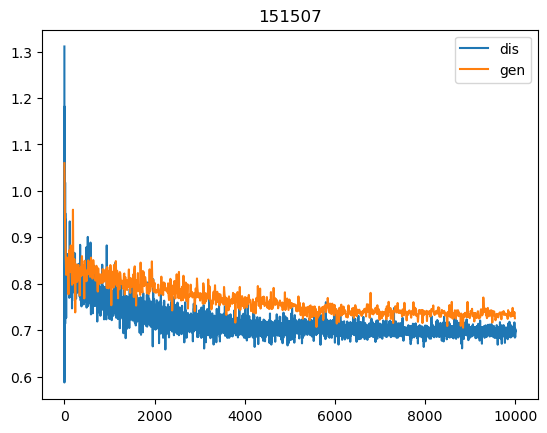

Adversarial training for ST slide 151508: 
Start adversarial training...


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/25 [00:00<?, ?it/s]

epoch: 0 gen train loss: 0.845773 dis train loss: 0.838447 dis train accu: 0.492283 
epoch: 1 gen train loss: 0.832598 dis train loss: 0.824511 dis train accu: 0.492347 
epoch: 2 gen train loss: 0.82225 dis train loss: 0.816261 dis train accu: 0.4946 
epoch: 3 gen train loss: 0.82568 dis train loss: 0.80664 dis train accu: 0.500383 
epoch: 4 gen train loss: 0.815231 dis train loss: 0.810055 dis train accu: 0.496896 
epoch: 5 gen train loss: 0.82507 dis train loss: 0.801746 dis train accu: 0.499957 
epoch: 6 gen train loss: 0.835603 dis train loss: 0.794499 dis train accu: 0.504571 
epoch: 7 gen train loss: 0.821298 dis train loss: 0.789184 dis train accu: 0.505634 
epoch: 8 gen train loss: 0.820252 dis train loss: 0.792459 dis train accu: 0.504018 
epoch: 9 gen train loss: 0.813543 dis train loss: 0.786821 dis train accu: 0.503529 
epoch: 10 gen train loss: 0.833146 dis train loss: 0.785956 dis train accu: 0.504486 
epoch: 11 gen train loss: 0.822467 dis train loss: 0.781908 dis train 

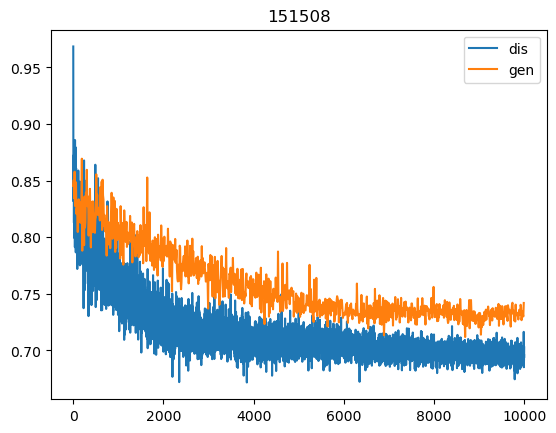

Adversarial training for ST slide 151509: 
Start adversarial training...


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/25 [00:00<?, ?it/s]

epoch: 0 gen train loss: 0.668206 dis train loss: 0.874327 dis train accu: 0.504209 
epoch: 1 gen train loss: 0.827943 dis train loss: 0.822257 dis train accu: 0.498482 
epoch: 2 gen train loss: 0.826666 dis train loss: 0.814183 dis train accu: 0.498217 
epoch: 3 gen train loss: 0.834466 dis train loss: 0.809565 dis train accu: 0.500051 
epoch: 4 gen train loss: 0.836125 dis train loss: 0.807363 dis train accu: 0.503251 
epoch: 5 gen train loss: 0.815875 dis train loss: 0.804164 dis train accu: 0.498563 
epoch: 6 gen train loss: 0.828903 dis train loss: 0.797249 dis train accu: 0.503006 
epoch: 7 gen train loss: 0.835453 dis train loss: 0.794337 dis train accu: 0.504677 
epoch: 8 gen train loss: 0.830089 dis train loss: 0.790505 dis train accu: 0.505737 
epoch: 9 gen train loss: 0.838883 dis train loss: 0.789834 dis train accu: 0.504331 
epoch: 10 gen train loss: 0.81965 dis train loss: 0.782092 dis train accu: 0.504474 
epoch: 11 gen train loss: 0.828165 dis train loss: 0.782794 dis t

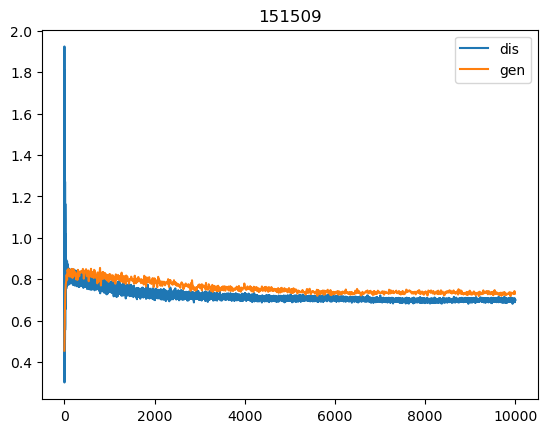

Adversarial training for ST slide 151510: 
Start adversarial training...


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/25 [00:00<?, ?it/s]

epoch: 0 gen train loss: 0.886489 dis train loss: 0.850948 dis train accu: 0.488341 
epoch: 1 gen train loss: 0.824968 dis train loss: 0.816106 dis train accu: 0.496045 
epoch: 2 gen train loss: 0.830854 dis train loss: 0.810175 dis train accu: 0.498012 
epoch: 3 gen train loss: 0.8364 dis train loss: 0.805454 dis train accu: 0.5 
epoch: 4 gen train loss: 0.835778 dis train loss: 0.801607 dis train accu: 0.503086 
epoch: 5 gen train loss: 0.820847 dis train loss: 0.799993 dis train accu: 0.50147 
epoch: 6 gen train loss: 0.83532 dis train loss: 0.797688 dis train accu: 0.502589 
epoch: 7 gen train loss: 0.831799 dis train loss: 0.790985 dis train accu: 0.500953 
epoch: 8 gen train loss: 0.813916 dis train loss: 0.79093 dis train accu: 0.505053 
epoch: 9 gen train loss: 0.831571 dis train loss: 0.785453 dis train accu: 0.506606 
epoch: 10 gen train loss: 0.813409 dis train loss: 0.780831 dis train accu: 0.506792 
epoch: 11 gen train loss: 0.827642 dis train loss: 0.779577 dis train accu

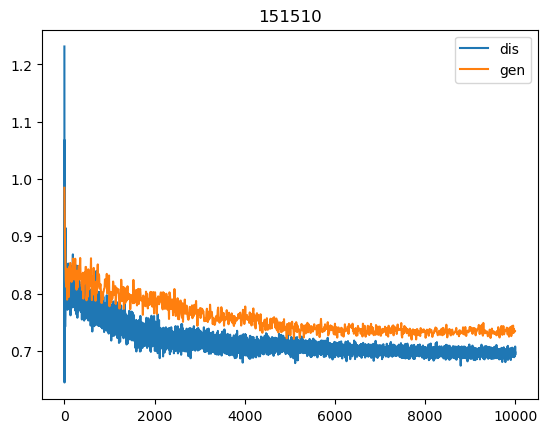

Adversarial training for ST slide 151669: 
Start adversarial training...


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0 gen train loss: 0.738784 dis train loss: 0.841385 dis train accu: 0.503407 
epoch: 1 gen train loss: 0.831719 dis train loss: 0.817995 dis train accu: 0.501344 
epoch: 2 gen train loss: 0.836514 dis train loss: 0.813565 dis train accu: 0.503746 
epoch: 3 gen train loss: 0.836215 dis train loss: 0.811823 dis train accu: 0.50325 
epoch: 4 gen train loss: 0.843789 dis train loss: 0.805955 dis train accu: 0.505365 
epoch: 5 gen train loss: 0.841699 dis train loss: 0.806398 dis train accu: 0.50325 
epoch: 6 gen train loss: 0.831113 dis train loss: 0.801195 dis train accu: 0.506096 
epoch: 7 gen train loss: 0.827447 dis train loss: 0.79848 dis train accu: 0.505678 
epoch: 8 gen train loss: 0.837189 dis train loss: 0.789703 dis train accu: 0.510038 
epoch: 9 gen train loss: 0.845632 dis train loss: 0.796707 dis train accu: 0.501867 
epoch: 10 gen train loss: 0.831943 dis train loss: 0.789944 dis train accu: 0.503616 
epoch: 11 gen train loss: 0.821224 dis train loss: 0.786373 dis tra

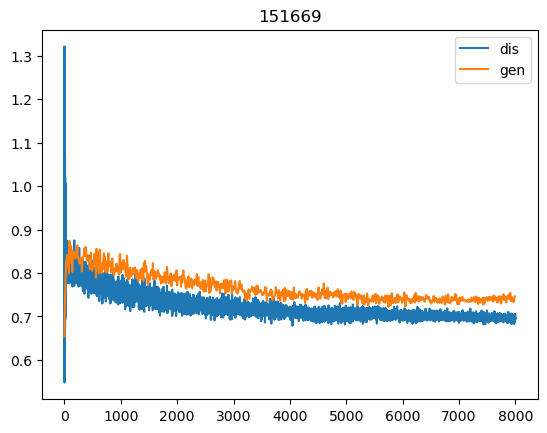

Adversarial training for ST slide 151670: 
Start adversarial training...


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0 gen train loss: 0.759467 dis train loss: 0.839573 dis train accu: 0.506135 
epoch: 1 gen train loss: 0.848182 dis train loss: 0.823963 dis train accu: 0.493198 
epoch: 2 gen train loss: 0.823558 dis train loss: 0.808728 dis train accu: 0.507895 
epoch: 3 gen train loss: 0.833148 dis train loss: 0.810645 dis train accu: 0.504881 
epoch: 4 gen train loss: 0.842187 dis train loss: 0.802846 dis train accu: 0.507522 
epoch: 5 gen train loss: 0.848708 dis train loss: 0.800583 dis train accu: 0.507682 
epoch: 6 gen train loss: 0.847847 dis train loss: 0.80442 dis train accu: 0.502747 
epoch: 7 gen train loss: 0.842824 dis train loss: 0.795647 dis train accu: 0.511016 
epoch: 8 gen train loss: 0.822146 dis train loss: 0.794532 dis train accu: 0.505708 
epoch: 9 gen train loss: 0.832827 dis train loss: 0.78981 dis train accu: 0.509202 
epoch: 10 gen train loss: 0.829201 dis train loss: 0.786721 dis train accu: 0.511336 
epoch: 11 gen train loss: 0.835805 dis train loss: 0.792533 dis tr

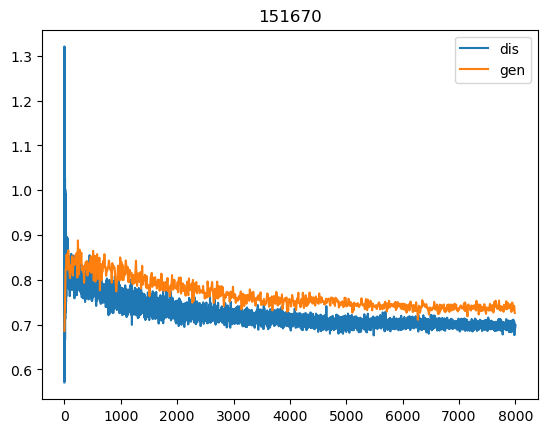

Adversarial training for ST slide 151671: 
Start adversarial training...


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/25 [00:00<?, ?it/s]

epoch: 0 gen train loss: 0.86124 dis train loss: 0.848775 dis train accu: 0.492161 
epoch: 1 gen train loss: 0.85485 dis train loss: 0.81842 dis train accu: 0.509021 
epoch: 2 gen train loss: 0.851493 dis train loss: 0.817011 dis train accu: 0.505058 
epoch: 3 gen train loss: 0.856986 dis train loss: 0.809841 dis train accu: 0.505146 
epoch: 4 gen train loss: 0.854871 dis train loss: 0.813623 dis train accu: 0.501927 
epoch: 5 gen train loss: 0.844846 dis train loss: 0.80452 dis train accu: 0.507576 
epoch: 6 gen train loss: 0.821627 dis train loss: 0.808892 dis train accu: 0.502978 
epoch: 7 gen train loss: 0.82003 dis train loss: 0.80264 dis train accu: 0.50162 
epoch: 8 gen train loss: 0.842254 dis train loss: 0.800807 dis train accu: 0.502474 
epoch: 9 gen train loss: 0.819581 dis train loss: 0.801167 dis train accu: 0.500876 
epoch: 10 gen train loss: 0.812832 dis train loss: 0.80048 dis train accu: 0.498205 
epoch: 11 gen train loss: 0.80267 dis train loss: 0.795537 dis train acc

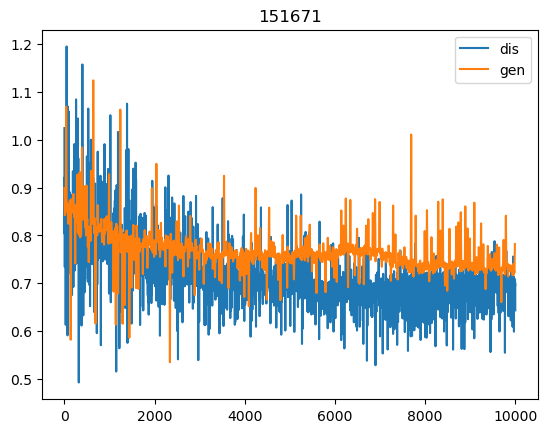

Adversarial training for ST slide 151672: 
Start adversarial training...


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0 gen train loss: 0.814814 dis train loss: 0.842754 dis train accu: 0.502682 
epoch: 1 gen train loss: 0.871182 dis train loss: 0.817851 dis train accu: 0.509944 
epoch: 2 gen train loss: 0.847131 dis train loss: 0.813971 dis train accu: 0.508422 
epoch: 3 gen train loss: 0.841428 dis train loss: 0.813836 dis train accu: 0.508347 
epoch: 4 gen train loss: 0.846386 dis train loss: 0.811884 dis train accu: 0.507299 
epoch: 5 gen train loss: 0.842794 dis train loss: 0.8099 dis train accu: 0.50388 
epoch: 6 gen train loss: 0.843363 dis train loss: 0.809874 dis train accu: 0.506201 
epoch: 7 gen train loss: 0.829284 dis train loss: 0.808536 dis train accu: 0.499389 
epoch: 8 gen train loss: 0.841092 dis train loss: 0.804125 dis train accu: 0.504329 
epoch: 9 gen train loss: 0.830973 dis train loss: 0.801795 dis train accu: 0.506026 
epoch: 10 gen train loss: 0.828855 dis train loss: 0.794475 dis train accu: 0.50685 
epoch: 11 gen train loss: 0.827912 dis train loss: 0.79091 dis train

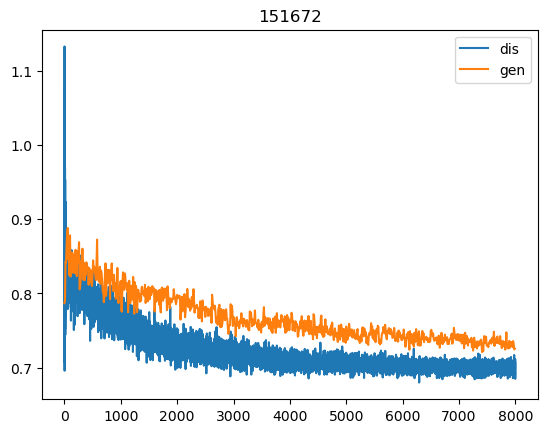

Adversarial training for ST slide 151673: 
Start adversarial training...


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0 gen train loss: 0.943702 dis train loss: 0.873998 dis train accu: 0.485325 
epoch: 1 gen train loss: 0.855762 dis train loss: 0.825539 dis train accu: 0.498887 
epoch: 2 gen train loss: 0.847474 dis train loss: 0.815826 dis train accu: 0.502945 
epoch: 3 gen train loss: 0.862319 dis train loss: 0.80881 dis train accu: 0.506689 
epoch: 4 gen train loss: 0.844761 dis train loss: 0.808823 dis train accu: 0.508732 
epoch: 5 gen train loss: 0.842323 dis train loss: 0.80103 dis train accu: 0.51347 
epoch: 6 gen train loss: 0.840033 dis train loss: 0.804818 dis train accu: 0.504438 
epoch: 7 gen train loss: 0.839047 dis train loss: 0.794617 dis train accu: 0.511873 
epoch: 8 gen train loss: 0.839893 dis train loss: 0.793829 dis train accu: 0.512816 
epoch: 9 gen train loss: 0.835692 dis train loss: 0.792408 dis train accu: 0.506951 
epoch: 10 gen train loss: 0.832696 dis train loss: 0.793708 dis train accu: 0.509438 
epoch: 11 gen train loss: 0.841005 dis train loss: 0.790704 dis tra

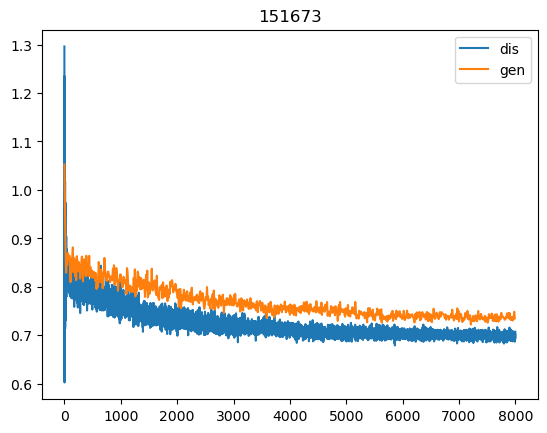

Adversarial training for ST slide 151674: 
Start adversarial training...


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0 gen train loss: 0.86704 dis train loss: 0.85562 dis train accu: 0.489587 
epoch: 1 gen train loss: 0.834211 dis train loss: 0.835847 dis train accu: 0.491933 
epoch: 2 gen train loss: 0.851084 dis train loss: 0.823979 dis train accu: 0.496989 
epoch: 3 gen train loss: 0.826767 dis train loss: 0.818329 dis train accu: 0.497824 
epoch: 4 gen train loss: 0.846138 dis train loss: 0.816272 dis train accu: 0.497954 
epoch: 5 gen train loss: 0.839226 dis train loss: 0.809651 dis train accu: 0.50533 
epoch: 6 gen train loss: 0.833881 dis train loss: 0.806907 dis train accu: 0.50348 
epoch: 7 gen train loss: 0.833082 dis train loss: 0.80411 dis train accu: 0.50507 
epoch: 8 gen train loss: 0.839826 dis train loss: 0.800341 dis train accu: 0.507259 
epoch: 9 gen train loss: 0.856153 dis train loss: 0.800462 dis train accu: 0.504653 
epoch: 10 gen train loss: 0.819528 dis train loss: 0.795291 dis train accu: 0.506712 
epoch: 11 gen train loss: 0.83483 dis train loss: 0.797058 dis train a

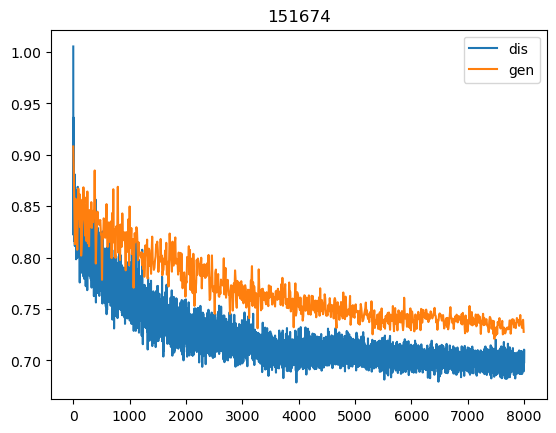

Adversarial training for ST slide 151675: 
Start adversarial training...


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0 gen train loss: 0.83968 dis train loss: 0.848407 dis train accu: 0.493414 
epoch: 1 gen train loss: 0.8469 dis train loss: 0.833504 dis train accu: 0.492202 
epoch: 2 gen train loss: 0.861989 dis train loss: 0.821753 dis train accu: 0.49834 
epoch: 3 gen train loss: 0.842782 dis train loss: 0.814159 dis train accu: 0.506112 
epoch: 4 gen train loss: 0.844967 dis train loss: 0.81317 dis train accu: 0.500738 
epoch: 5 gen train loss: 0.835919 dis train loss: 0.808089 dis train accu: 0.502345 
epoch: 6 gen train loss: 0.843495 dis train loss: 0.802029 dis train accu: 0.503978 
epoch: 7 gen train loss: 0.831253 dis train loss: 0.798312 dis train accu: 0.50411 
epoch: 8 gen train loss: 0.83581 dis train loss: 0.792533 dis train accu: 0.510801 
epoch: 9 gen train loss: 0.829896 dis train loss: 0.789932 dis train accu: 0.50843 
epoch: 10 gen train loss: 0.841887 dis train loss: 0.788335 dis train accu: 0.508377 
epoch: 11 gen train loss: 0.836422 dis train loss: 0.786268 dis train ac

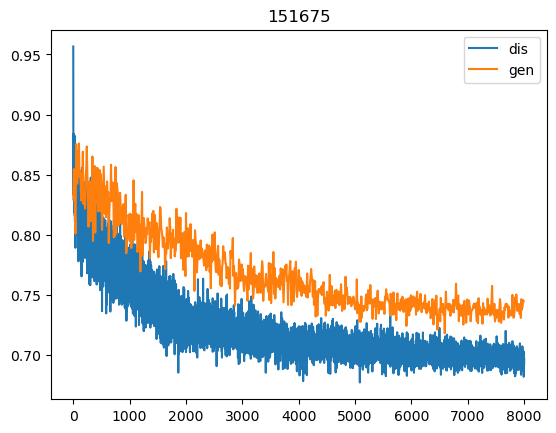

Adversarial training for ST slide 151676: 
Start adversarial training...


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Batch:   0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0 gen train loss: 0.926694 dis train loss: 0.865503 dis train accu: 0.48748 
epoch: 1 gen train loss: 0.836416 dis train loss: 0.836107 dis train accu: 0.49252 
epoch: 2 gen train loss: 0.85592 dis train loss: 0.825681 dis train accu: 0.498311 
epoch: 3 gen train loss: 0.836171 dis train loss: 0.817804 dis train accu: 0.503405 
epoch: 4 gen train loss: 0.835366 dis train loss: 0.816979 dis train accu: 0.499062 
epoch: 5 gen train loss: 0.836362 dis train loss: 0.813457 dis train accu: 0.49941 
epoch: 6 gen train loss: 0.838757 dis train loss: 0.805335 dis train accu: 0.503324 
epoch: 7 gen train loss: 0.842097 dis train loss: 0.803804 dis train accu: 0.502869 
epoch: 8 gen train loss: 0.845978 dis train loss: 0.798772 dis train accu: 0.506836 
epoch: 9 gen train loss: 0.832066 dis train loss: 0.79281 dis train accu: 0.509276 
epoch: 10 gen train loss: 0.838031 dis train loss: 0.793811 dis train accu: 0.506729 
epoch: 11 gen train loss: 0.825614 dis train loss: 0.791882 dis train

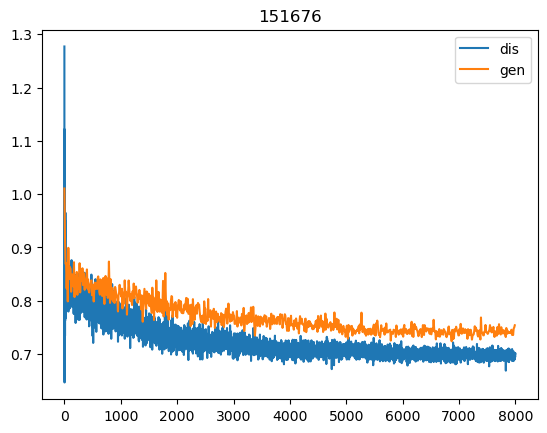

In [22]:
if TRAIN_USING_ALL_ST_SAMPLES:
    print(f"Adversarial training for all ST slides")
    save_folder = advtrain_folder

    best_checkpoint = torch.load(os.path.join(pretrain_folder, f"final_model.pth"))
    model = ADDAST(
        sc_mix_d["train"].shape[1],
        ncls_source=lab_mix_d["train"].shape[1],
        is_adda=True,
        **adda_kwargs,
    )

    model.source_encoder.load_state_dict(
        best_checkpoint["model"].source_encoder.state_dict()
    )
    model.clf.load_state_dict(best_checkpoint["model"].clf.state_dict())

    model.init_adv()
    model.dis.apply(initialize_weights)
    model.to(device)

    model.advtraining()

    train_adversarial_iters(
        model,
        save_folder,
        dataloader_source_train,
        dataloader_source_val,
        dataloader_target_train,
        dataloader_target_train_dis,
    )

else:
    for sample_id in st_sample_id_l:
        print(f"Adversarial training for ST slide {sample_id}: ")

        save_folder = os.path.join(advtrain_folder, sample_id)
        if not os.path.isdir(save_folder):
            os.makedirs(save_folder)

        best_checkpoint = torch.load(os.path.join(pretrain_folder, f"final_model.pth"))

        model = ADDAST(
            sc_mix_d["train"].shape[1],
            ncls_source=lab_mix_d["train"].shape[1],
            is_adda=True,
            **adda_kwargs,
        )

        model.apply(initialize_weights)

        # load state dicts
        # this makes it easier, if, say, the discriminator changes
        model.source_encoder.load_state_dict(
            best_checkpoint["model"].source_encoder.state_dict()
        )

        model.clf.load_state_dict(best_checkpoint["model"].clf.state_dict())

        model.init_adv()
        model.dis.apply(initialize_weights)

        model.to(device)

        model.advtraining()

        loss_history_running, loss_history_gen_running = train_adversarial_iters(
            model,
            save_folder,
            dataloader_source_train,
            dataloader_source_val,
            dataloader_target_train_d[sample_id],
            dataloader_target_train_dis_d[sample_id],
        )
        loss_history_gen_running = np.ravel(loss_history_gen_running)
        x = np.arange(
            0,
            len(loss_history_gen_running) * (DIS_LOOP_FACTOR * 2),
            DIS_LOOP_FACTOR * 2,
        )

        plt.plot(np.ravel(loss_history_running), label="dis")
        plt.plot(x, loss_history_gen_running, label="gen")
        plt.legend()
        plt.title(sample_id)
        plt.show()


## Evaluation of latent space

In [23]:
# from sklearn.decomposition import PCA
# from sklearn import model_selection
# from sklearn.ensemble import RandomForestClassifier


# for sample_id in st_sample_id_l:
#     best_checkpoint = torch.load(
#         os.path.join(advtrain_folder, sample_id, f"final_model.pth")
#     )
#     model = best_checkpoint["model"]
#     model.to(device)

#     model.eval()
#     model.target_inference()

#     with torch.no_grad():
#         source_emb = model.source_encoder(torch.Tensor(sc_mix_train_s).to(device))
#         target_emb = model.target_encoder(
#             torch.Tensor(mat_sp_test_s_d[sample_id]).to(device)
#         )

#         y_dis = torch.cat(
#             [
#                 torch.zeros(source_emb.shape[0], device=device, dtype=torch.long),
#                 torch.ones(target_emb.shape[0], device=device, dtype=torch.long),
#             ]
#         )

#         emb = torch.cat([source_emb, target_emb])

#         emb = emb.detach().cpu().numpy()
#         y_dis = y_dis.detach().cpu().numpy()

#     (emb_train, emb_test, y_dis_train, y_dis_test,) = model_selection.train_test_split(
#         emb,
#         y_dis,
#         test_size=0.2,
#         random_state=225,
#         stratify=y_dis,
#     )

#     pca = PCA(n_components=50)
#     pca.fit(emb_train)

#     emb_train_50 = pca.transform(emb_train)
#     emb_test_50 = pca.transform(emb_test)

#     clf = RandomForestClassifier(random_state=145, n_jobs=-1)
#     clf.fit(emb_train_50, y_dis_train)
#     accu_train = clf.score(emb_train_50, y_dis_train)
#     accu_test = clf.score(emb_test_50, y_dis_test)
#     class_proportions = np.mean(y_dis)

#     print(
#         "Training accuracy: {}, Test accuracy: {}, Class proportions: {}".format(
#             accu_train, accu_test, class_proportions
#         )
#     )


 # 4. Predict cell fraction of spots and visualization

In [24]:
# pred_sp_d, pred_sp_noda_d = {}, {}
# if TRAIN_USING_ALL_ST_SAMPLES:
#     best_checkpoint = torch.load(os.path.join(advtrain_folder, f"final_model.pth"))
#     model = best_checkpoint["model"]
#     model.to(device)

#     model.eval()
#     model.target_inference()
#     with torch.no_grad():
#         for sample_id in st_sample_id_l:
#             pred_sp_d[sample_id] = (
#                 torch.exp(
#                     model(torch.Tensor(mat_sp_test_s_d[sample_id]).to(device))
#                 )
#                 .detach()
#                 .cpu()
#                 .numpy()
#             )

# else:
#     for sample_id in st_sample_id_l:
#         best_checkpoint = torch.load(
#             os.path.join(advtrain_folder, sample_id, f"final_model.pth")
#         )
#         model = best_checkpoint["model"]
#         model.to(device)

#         model.eval()
#         model.target_inference()

#         with torch.no_grad():
#             pred_sp_d[sample_id] = (
#                 torch.exp(
#                     model(torch.Tensor(mat_sp_test_s_d[sample_id]).to(device))
#                 )
#                 .detach()
#                 .cpu()
#                 .numpy()
#             )


# best_checkpoint = torch.load(os.path.join(pretrain_folder, f"best_model.pth"))
# model = best_checkpoint["model"]
# model.to(device)

# model.eval()
# model.set_encoder("source")

# with torch.no_grad():
#     for sample_id in st_sample_id_l:
#         pred_sp_noda_d[sample_id] = (
#             torch.exp(model(torch.Tensor(mat_sp_test_s_d[sample_id]).to(device)))
#             .detach()
#             .cpu()
#             .numpy()
#         )


In [25]:
# adata_spatialLIBD = sc.read_h5ad(
#     os.path.join(PROCESSED_DATA_DIR, "adata_spatialLIBD.h5ad")
# )

# adata_spatialLIBD_d = {}
# for sample_id in st_sample_id_l:
#     adata_spatialLIBD_d[sample_id] = adata_spatialLIBD[
#         adata_spatialLIBD.obs.sample_id == sample_id
#     ]
#     adata_spatialLIBD_d[sample_id].obsm["spatial"] = (
#         adata_spatialLIBD_d[sample_id].obs[["X", "Y"]].values
#     )


In [26]:
# num_name_exN_l = []
# for k, v in sc_sub_dict.items():
#     if "Ex" in v:
#         num_name_exN_l.append((k, v, int(v.split("_")[1])))
# num_name_exN_l.sort(key=lambda a: a[2])
# num_name_exN_l


In [27]:
# Ex_to_L_d = {
#     1: {5, 6},
#     2: {5},
#     3: {4, 5},
#     4: {6},
#     5: {5},
#     6: {4, 5, 6},
#     7: {4, 5, 6},
#     8: {5, 6},
#     9: {5, 6},
#     10: {2, 3, 4},
# }


In [28]:
# numlist = [t[0] for t in num_name_exN_l]
# Ex_l = [t[2] for t in num_name_exN_l]
# num_to_ex_d = dict(zip(numlist, Ex_l))


In [29]:
# def plot_cellfraction(visnum, adata, pred_sp, ax=None):
#     """Plot predicted cell fraction for a given visnum"""
#     adata.obs["Pred_label"] = pred_sp[:, visnum]
#     # vmin = 0
#     # vmax = np.amax(pred_sp)

#     sc.pl.spatial(
#         adata,
#         img_key="hires",
#         color="Pred_label",
#         palette="Set1",
#         size=1.5,
#         legend_loc=None,
#         title=f"{sc_sub_dict[visnum]}",
#         spot_size=100,
#         show=False,
#         # vmin=vmin,
#         # vmax=vmax,
#         ax=ax,
#     )


In [30]:
# def plot_roc(visnum, adata, pred_sp, name, ax=None):
#     """Plot ROC for a given visnum"""

#     def layer_to_layer_number(x):
#         for char in x:
#             if char.isdigit():
#                 if int(char) in Ex_to_L_d[num_to_ex_d[visnum]]:
#                     return 1
#         return 0

#     y_pred = pred_sp[:, visnum]
#     y_true = adata.obs["spatialLIBD"].map(layer_to_layer_number).fillna(0)
#     # print(y_true)
#     # print(y_true.isna().sum())
#     RocCurveDisplay.from_predictions(y_true=y_true, y_pred=y_pred, name=name, ax=ax)


In [31]:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), constrained_layout=True)

# sc.pl.spatial(
#     adata_spatialLIBD_d[SAMPLE_ID_N],
#     img_key=None,
#     color="spatialLIBD",
#     palette="Accent_r",
#     size=1.5,
#     title=SAMPLE_ID_N,
#     # legend_loc = 4,
#     spot_size=100,
#     show=False,
#     ax=ax,
# )

# ax.axis("equal")
# ax.set_xlabel("")
# ax.set_ylabel("")

# fig.show()


In [32]:
# fig, ax = plt.subplots(2, 5, figsize=(20, 8), constrained_layout=True)

# for i, num in enumerate(numlist):
#     plot_cellfraction(
#         num, adata_spatialLIBD_d[SAMPLE_ID_N], pred_sp_d[SAMPLE_ID_N], ax.flat[i]
#     )
#     ax.flat[i].axis("equal")
#     ax.flat[i].set_xlabel("")
#     ax.flat[i].set_ylabel("")

# fig.show()

# fig, ax = plt.subplots(
#     2, 5, figsize=(20, 8), constrained_layout=True, sharex=True, sharey=True
# )

# for i, num in enumerate(numlist):
#     plot_roc(
#         num,
#         adata_spatialLIBD_d[SAMPLE_ID_N],
#         pred_sp_d[SAMPLE_ID_N],
#         "ADDA",
#         ax.flat[i],
#     )
#     plot_roc(
#         num,
#         adata_spatialLIBD_d[SAMPLE_ID_N],
#         pred_sp_noda_d[SAMPLE_ID_N],
#         "NN_wo_da",
#         ax.flat[i],
#     )
#     ax.flat[i].plot([0, 1], [0, 1], transform=ax.flat[i].transAxes, ls="--", color="k")
#     ax.flat[i].set_aspect("equal")
#     ax.flat[i].set_xlim([0, 1])
#     ax.flat[i].set_ylim([0, 1])

#     ax.flat[i].set_title(f"{sc_sub_dict[num]}")

#     if i >= len(numlist) - 5:
#         ax.flat[i].set_xlabel("FPR")
#     else:
#         ax.flat[i].set_xlabel("")
#     if i % 5 == 0:
#         ax.flat[i].set_ylabel("TPR")
#     else:
#         ax.flat[i].set_ylabel("")

# fig.show()


In [33]:
# if TRAIN_USING_ALL_ST_SAMPLES:
#     best_checkpoint = torch.load(os.path.join(advtrain_folder, f"final_model.pth"))
# else:
#     best_checkpoint = torch.load(
#         os.path.join(advtrain_folder, SAMPLE_ID_N, f"final_model.pth")
#     )

# model = best_checkpoint["model"]
# model.to(device)

# model.eval()
# model.set_encoder("source")

# with torch.no_grad():
#     pred_mix = (
#         torch.exp(model(torch.Tensor(sc_mix_test_s).to(device)))
#         .detach()
#         .cpu()
#         .numpy()
#     )

# cell_type_nums = sc_sub_dict.keys()
# nrows = ceil(len(cell_type_nums) / 5)

# line_kws = {"color": "tab:orange"}
# scatter_kws = {"s": 5}

# props = dict(facecolor="w", alpha=0.5)

# fig, ax = plt.subplots(
#     nrows,
#     5,
#     figsize=(25, 5 * nrows),
#     constrained_layout=True,
#     sharex=False,
#     sharey=True,
# )
# for i, visnum in enumerate(cell_type_nums):
#     sns.regplot(
#         x=pred_mix[:, visnum],
#         y=lab_mix_test[:, visnum],
#         line_kws=line_kws,
#         scatter_kws=scatter_kws,
#         ax=ax.flat[i],
#     ).set_title(sc_sub_dict[visnum])

#     ax.flat[i].set_aspect("equal")
#     ax.flat[i].set_xlabel("Predicted Proportion")

#     if i % 5 == 0:
#         ax.flat[i].set_ylabel("True Proportion")
#     else:
#         ax.flat[i].set_ylabel("")
#     ax.flat[i].set_xlim([0, 1])
#     ax.flat[i].set_ylim([0, 1])

#     textstr = (
#         f"MSE: {mean_squared_error(pred_mix[:,visnum], lab_mix_test[:,visnum]):.5f}"
#     )

#     # place a text box in upper left in axes coords
#     ax.flat[i].text(
#         0.95,
#         0.05,
#         textstr,
#         transform=ax.flat[i].transAxes,
#         verticalalignment="bottom",
#         horizontalalignment="right",
#         bbox=props,
#     )

# for i in range(len(cell_type_nums), nrows * 5):
#     ax.flat[i].axis("off")

# plt.show()
